In [1]:
import os

# Dask Configuration

In [2]:
from dask_jobqueue import PBSCluster
from pathlib import Path

# Define the working directory path
working_directory = str(Path.cwd())

# Launch a scheduler and workers on HPC via PBS
cluster = PBSCluster(
     cores=4,
     memory="8GB",
     processes=1,
     queue="tamirQ",
     walltime="02:30:00",
     scheduler_options={"dashboard_address": ":12435"},  # FIXME - this is the port we need to define...
     # Additional custom options
     log_directory="dask-logs",
     #worker_extra_args=["--lifetime", "25m", "--lifetime-stagger", "4m"],  # for walltime="00:30:00"
     job_script_prologue=[f"cd {working_directory}"]
)

/tamir2/moranb/microbiome/Igem_TAU_2021/venv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 12435 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39946 instead
  warnings.warn(


In [3]:
cluster

Dashboard: http://132.66.112.146:39946/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://132.66.112.146:45372,Workers: 0
Dashboard: http://132.66.112.146:39946/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
cluster.adapt(minimum=30, maximum=60)
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q tamirQ
#PBS -l select=1:ncpus=4:mem=7630MB
#PBS -l walltime=02:30:00
#PBS -e dask-logs/
#PBS -o dask-logs/
cd /tamir2/moranb/microbiome/Igem_TAU_2021
/tamir2/moranb/microbiome/Igem_TAU_2021/venv/bin/python -m distributed.cli.dask_worker tcp://132.66.112.146:45372 --nthreads 4 --memory-limit 7.45GiB --name dummy-name --nanny --death-timeout 60



In [5]:
from dask.distributed import Client, progress, wait, get_client, get_worker
client = Client(cluster)

In [6]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://132.66.112.146:39946/status,
Dashboard: http://132.66.112.146:39946/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://132.66.112.146:45372,Workers: 0
Dashboard: http://132.66.112.146:39946/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
import dask.bag as db
import dask.dataframe as dd
from dask import delayed, compute, persist
import json
import matplotlib
from matplotlib import lines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Analysis for endogenous genes

In [8]:
import operator
from Bio import SeqIO
from analysis.orf_model_analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data
from analysis.orf_model_analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus

from modules.main import run_modules
from modules.user_IO.input_functions import extract_gene_data

In [9]:
output_path = "/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/endogenous_genes"
optimization_cub_index = "CAI"

In [10]:
def get_df_for_run_configuration(configuration, organism, optimization_method):
    configuration_output_path = os.path.join(output_path, configuration, organism)
    results_dir = F"{configuration_output_path}/{optimization_method}/"
    return dd.read_json([F"{results_dir}/{file}" for file in os.listdir(results_dir)], orient='records', lines=True)

In [11]:
def get_highly_expressed_gene_names(gb_file_path, expression_csv_fid):
    _, estimated_expression = extract_gene_data(genbank_path=gb_file_path, expression_csv_fid=mrna_levels_path)

    estimated_expression_threshold = 0.3
    sorted_estimated_expression = dict(
        sorted(estimated_expression.items(), key=operator.itemgetter(1), reverse=True)
    )
    highly_expressed_genes_count = round(len(sorted_estimated_expression) * estimated_expression_threshold)
    highly_expressed_names = list(sorted_estimated_expression.keys())[:highly_expressed_genes_count]
    return highly_expressed_names

In [12]:
def get_scores_for_organism_by_configuration(configuration, organism, score_name):
    df_zscore_ratio = get_df_for_run_configuration(configuration, organism, "zscore_bulk_aa_ratio")
    df_zscore_diff = get_df_for_run_configuration(configuration, organism, "zscore_bulk_aa_diff")
    zscore_ratio_scores = df_zscore_ratio[score_name].compute()
    zscore_diff_scores = df_zscore_diff[score_name].compute()
    
    df_single_codon_ratio = get_df_for_run_configuration(configuration, organism, "single_codon_ratio")
    df_single_codon_diff = get_df_for_run_configuration(configuration, organism, "single_codon_diff")
    single_codon_ratio_scores = df_single_codon_ratio[score_name].compute()
    single_codon_diff_scores = df_single_codon_diff[score_name].compute()

    return zscore_ratio_scores, zscore_diff_scores, single_codon_ratio_scores, single_codon_diff_scores

In [13]:
def get_scores_df_for_organism_by_configuration(configuration, organism):
    df_zscore_ratio = get_df_for_run_configuration(configuration, organism, "zscore_bulk_aa_ratio")
    df_zscore_diff = get_df_for_run_configuration(configuration, organism, "zscore_bulk_aa_diff")

    merged_zscore_df = dd.merge(df_zscore_ratio, df_zscore_diff, on='gene_name', how='inner', suffixes=('_zscore_ratio', '_zscore_diff'))
    
    df_single_codon_ratio = get_df_for_run_configuration(configuration, organism, "single_codon_ratio")
    df_single_codon_diff = get_df_for_run_configuration(configuration, organism, "single_codon_diff")

    merged_single_df = dd.merge(df_single_codon_ratio, df_single_codon_diff, on='gene_name', how='inner', suffixes=('_single_ratio', '_single_diff'))

    merged_df = dd.merge(merged_zscore_df, merged_single_df, on='gene_name', how='inner')
    return merged_df

In [71]:
def add_median_to_histogram(score_name, histogram, row, col, upper_limit):
    median_value = result[score_name].median()
    histogram[row][col].axvline(median_value, color="green", linestyle="dashed", label="median")
    histogram[row][col].text(median_value-1, upper_limit, f"median={median_value}")

### Escherichia-coli

In [14]:
organism = "Escherichia-coli"
gb_file_path = f"/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/example_data/{organism}.gb"
mrna_levels_path = f"/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/example_data/ecoli_mrna_level.csv"

# highly_expressed_names = get_highly_expressed_gene_names(gb_file_path, mrna_levels_path)

#### Escherichia-coli as wanted host 

In [15]:
configuration = "e_coli_optimized_True_bacillus_optimized_False"
result = get_scores_df_for_organism_by_configuration(configuration, organism)
result = result.compute()

# zscore_ratio_scores, zscore_diff_scores, single_codon_ratio_scores, single_codon_diff_scores = get_scores_for_organism_by_configuration(configuration, organism, "average_distance_score")

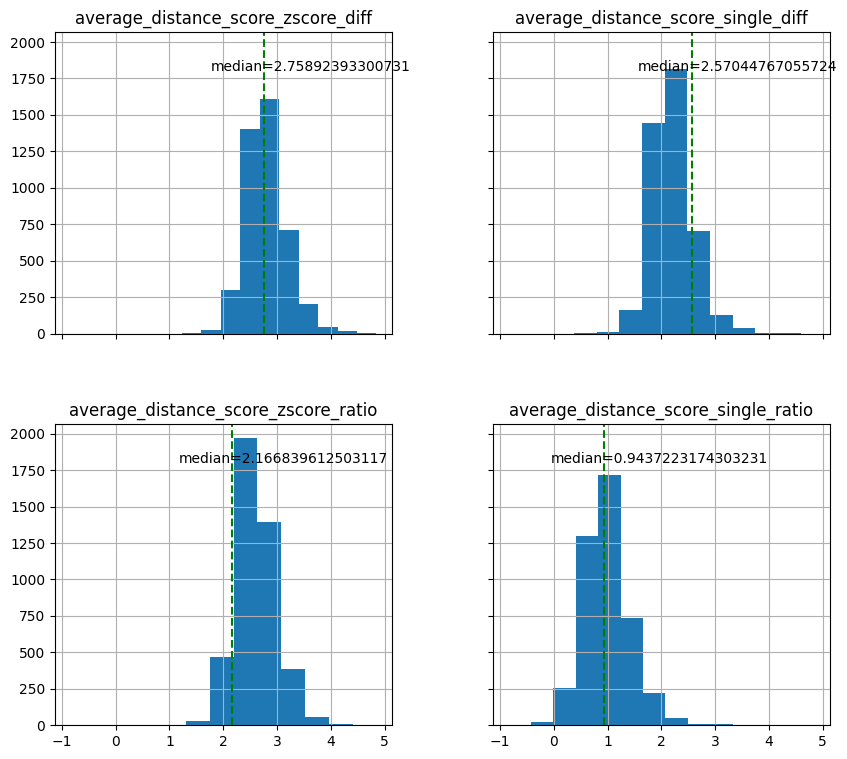

In [75]:
histogram = result[["average_distance_score_zscore_diff",  "average_distance_score_single_diff", "average_distance_score_zscore_ratio", "average_distance_score_single_ratio"]].hist(sharex=True, sharey=True,figsize=(10, 9))

add_median_to_histogram("average_distance_score_zscore_diff", histogram, 0, 0, 1800)
add_median_to_histogram("average_distance_score_single_diff", histogram, 1, 0, 1800)
add_median_to_histogram("average_distance_score_zscore_ratio", histogram, 0, 1, 1800)
add_median_to_histogram("average_distance_score_single_ratio", histogram, 1, 1, 1800)

### Single codon ratio vs. single codon diff

Text(0.5, 1.0, 'Correlation')

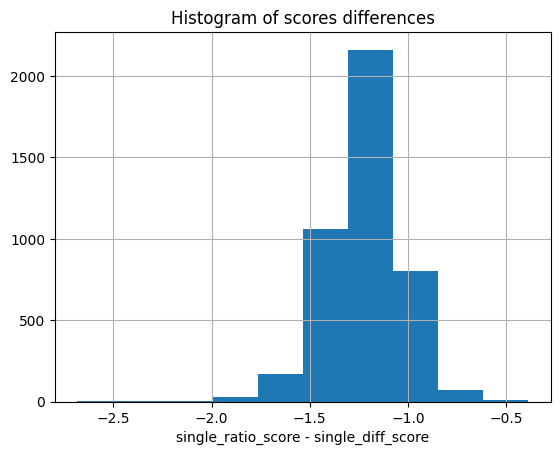

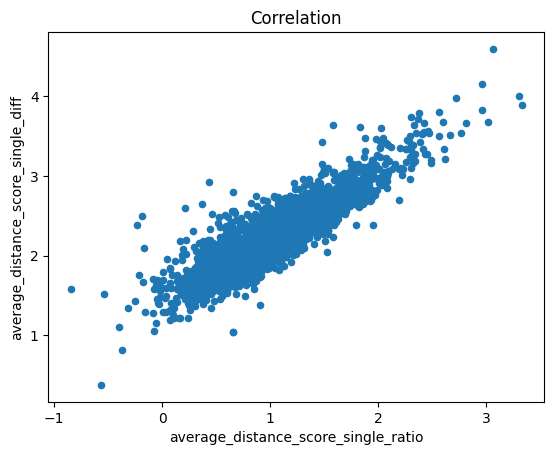

In [103]:
difference = result["average_distance_score_single_ratio"]-result["average_distance_score_single_diff"]
histogram = difference.hist()
histogram.set_xlabel("single_ratio_score - single_diff_score")
histogram.set_title("Histogram of scores differences")
scatter = result.plot.scatter(x="average_distance_score_single_ratio", y="average_distance_score_single_diff")
scatter.set_title("Correlation")

<Axes: >

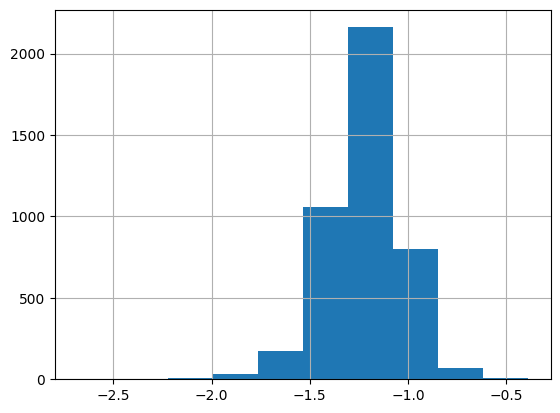

In [40]:
difference = result["average_distance_score_single_ratio"]-result["average_distance_score_single_diff"]
# difference = single_codon_ratio_scores.reset_index(drop=True) - single_codon_diff_scores.reset_index(drop=True)
difference.hist()

In [24]:
difference.median(), difference.mean()

(-1.2177393328535318, -1.221344557448308)

### Zscore diff vs. single codon diff

<Axes: >

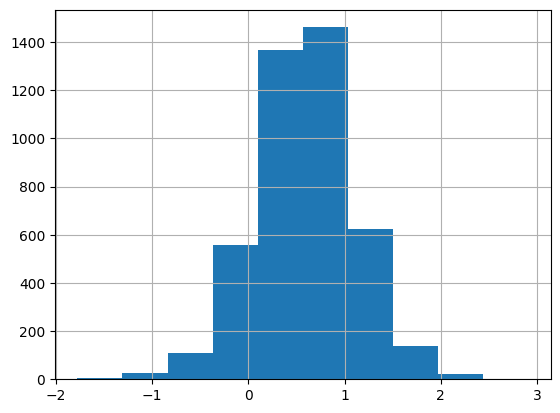

In [25]:
difference = zscore_diff_scores.reset_index(drop=True) - single_codon_diff_scores.reset_index(drop=True)
difference.hist()

In [26]:
difference.median(), difference.mean()

(0.5918900295145497, 0.5862297383768399)

### Zscore ratio vs. zscore diff

<Axes: >

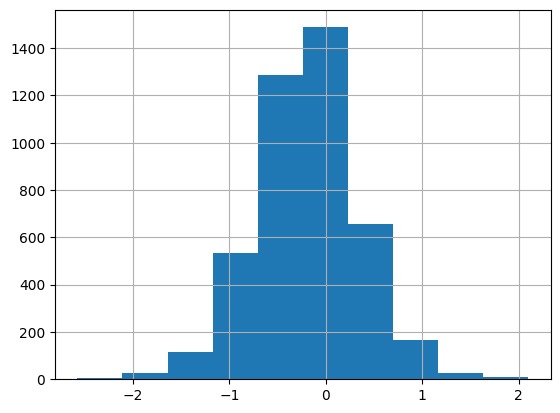

In [27]:
difference = zscore_ratio_scores.reset_index(drop=True) - zscore_diff_scores.reset_index(drop=True)
difference.hist()

In [28]:
difference.median(), difference.mean()

(-0.19018013340387507, -0.19308244677130118)

### Zscore ratio vs. single codon ratio

<Axes: >

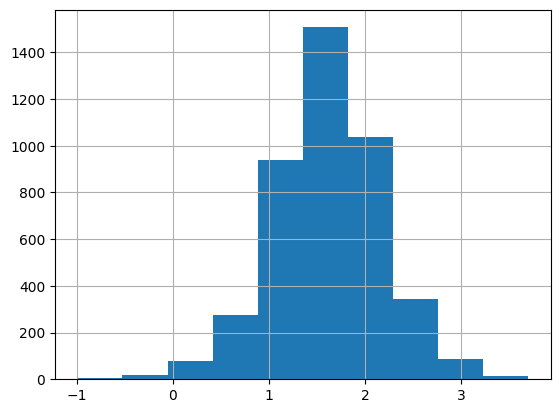

In [29]:
difference = zscore_ratio_scores.reset_index(drop=True) - single_codon_ratio_scores.reset_index(drop=True)
difference.hist()

In [30]:
difference.median(), difference.mean()

(1.616762673382338, 1.6144918490538467)

### Zscore ratio vs. single codon diff

<Axes: >

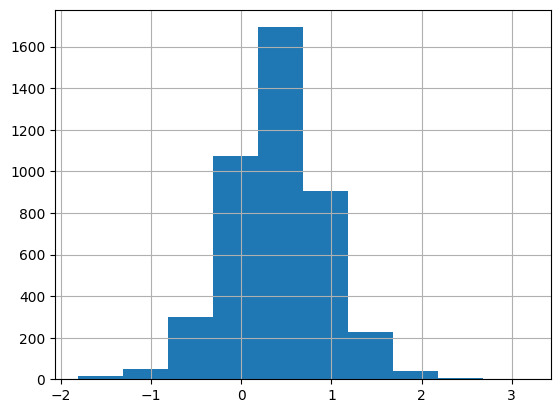

In [31]:
difference = zscore_ratio_scores.reset_index(drop=True) - single_codon_diff_scores.reset_index(drop=True)
difference.hist()

In [32]:
difference.median(), difference.mean()

(0.3950850163843387, 0.3931472916055388)

#### Escherichia-coli as unwanted host 

In [33]:
configuration = "e_coli_optimized_False_bacillus_optimized_True"

zscore_ratio_scores, zscore_diff_scores, single_codon_ratio_scores, single_codon_diff_scores = get_scores_for_organism_by_configuration(configuration, organism, "average_distance_score")

Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

<Axes: >

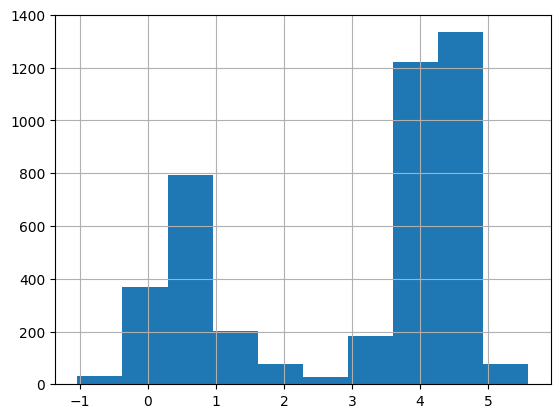

In [34]:
zscore_ratio_scores.hist()

In [35]:
zscore_ratio_scores.median(), zscore_ratio_scores.mean()

(4.012825211523985, 2.98547168556404)

<Axes: >

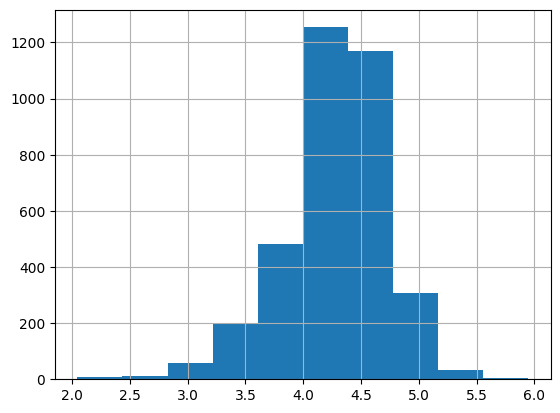

In [36]:
zscore_diff_scores.hist()

In [37]:
zscore_diff_scores.median(), zscore_diff_scores.mean()

(4.317139143997657, 4.275350171829274)

<Axes: >

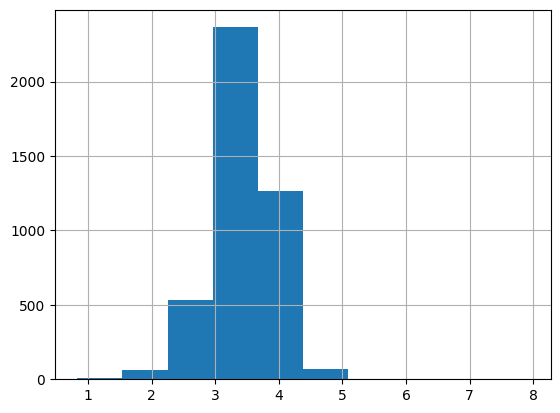

In [38]:
single_codon_ratio_scores.hist()

In [39]:
single_codon_ratio_scores.median(), single_codon_ratio_scores.mean()

(3.4726455860951893, 3.437530107479319)

<Axes: >

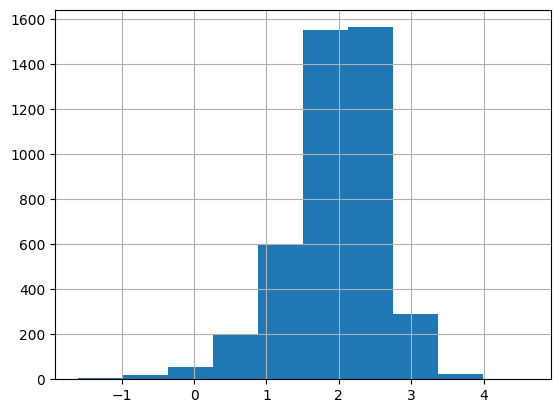

In [40]:
single_codon_diff_scores.hist()

In [41]:
single_codon_diff_scores.median(), single_codon_diff_scores.mean()

(2.0379889378000744, 1.9563017149253494)

### Single codon ratio vs. single codon diff

<Axes: >

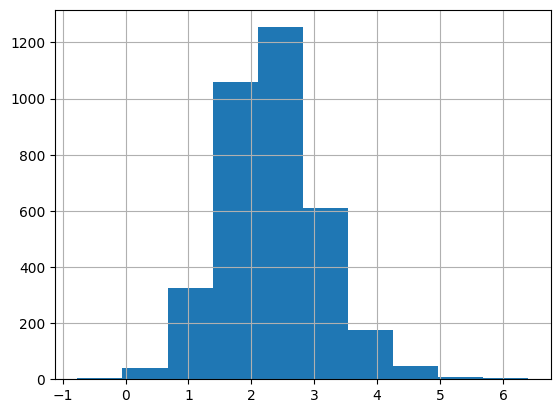

In [42]:
difference = zscore_diff_scores.reset_index(drop=True) - single_codon_diff_scores.reset_index(drop=True)
difference.hist()

In [43]:
difference.median(), difference.mean()

(2.2592556092392018, 2.3168686349699956)

### Zscore diff vs. single codon diff

<Axes: >

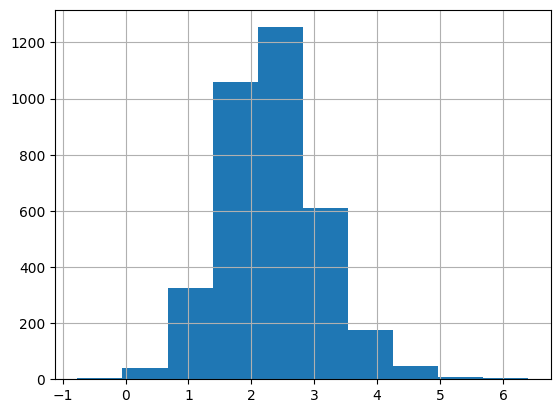

In [44]:
difference = zscore_diff_scores.reset_index(drop=True) - single_codon_diff_scores.reset_index(drop=True)
difference.hist()

In [45]:
difference.median(), difference.mean()

(2.2592556092392018, 2.3168686349699956)

### Zscore ratio vs. zscore diff

<Axes: >

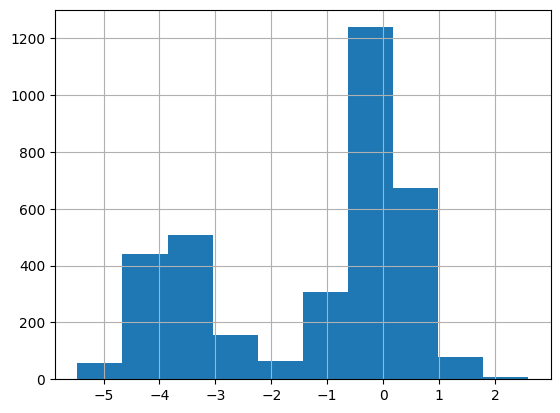

In [46]:
difference = zscore_ratio_scores.reset_index(drop=True) - zscore_diff_scores.reset_index(drop=True)
difference.hist()

In [47]:
difference.median(), difference.mean()

(-0.4253944273679533, -1.2754986867125109)

### Zscore ratio vs. single codon ratio

<Axes: >

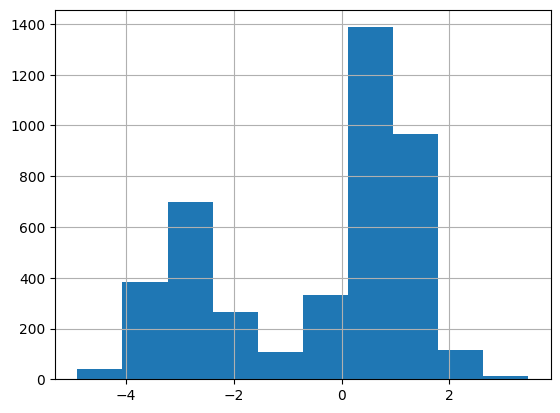

In [48]:
difference = zscore_ratio_scores.reset_index(drop=True) - single_codon_ratio_scores.reset_index(drop=True)
difference.hist()

In [49]:
difference.median(), difference.mean()

(0.3768497168498812, -0.4520584219152789)

### Bacillus-subtilis

In [50]:
organism =  "Bacillus-subtilis"

gb_file_path = f"/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/example_data/{organism}.gb"
mrna_levels_path = f"/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/example_data/bacillus_mrna_level.csv"

# highly_expressed_names = get_highly_expressed_gene_names(gb_file_path, mrna_levels_path)

#### Bacillus-subtilis as wanted host 

In [51]:
configuration = "e_coli_optimized_False_bacillus_optimized_True"

zscore_ratio_scores, zscore_diff_scores, single_codon_ratio_scores, single_codon_diff_scores = get_scores_for_organism_by_configuration(configuration, organism, "average_distance_score")

<Axes: >

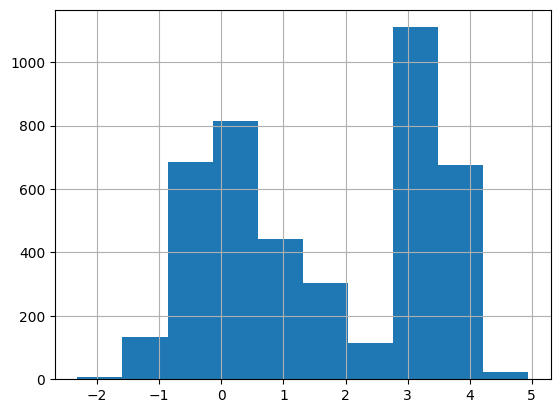

In [52]:
zscore_ratio_scores.hist()

In [54]:
zscore_ratio_scores.median(), zscore_ratio_scores.mean()

(1.4655025502491061, 1.6356185381060193)

<Axes: >

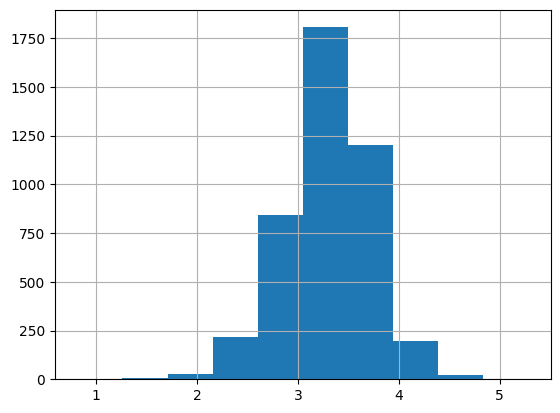

In [55]:
zscore_diff_scores.hist()

In [56]:
zscore_diff_scores.median(), zscore_diff_scores.mean()

(3.335239750401825, 3.305773462599186)

<Axes: >

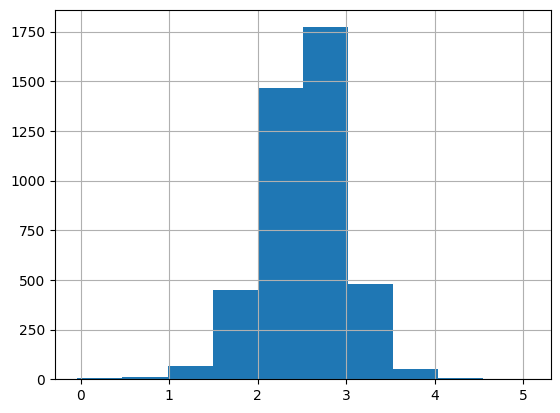

In [57]:
single_codon_ratio_scores.hist()

In [58]:
single_codon_ratio_scores.median(), single_codon_ratio_scores.mean()

(2.545735149772962, 2.5218648412938824)

<Axes: >

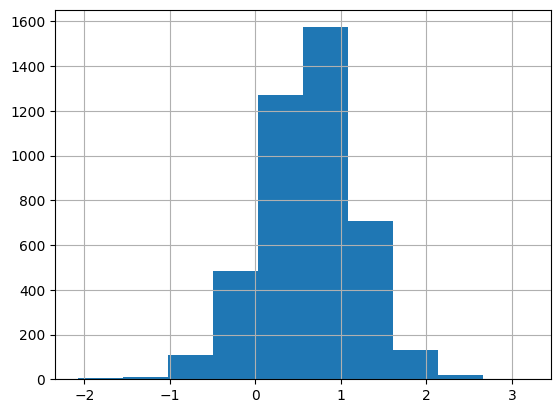

In [59]:
single_codon_diff_scores.hist()

In [61]:
single_codon_diff_scores.median(),single_codon_diff_scores.mean()

(0.647952763609356, 0.6258785927746872)

#### Bacillus-subtilis as unwanted host 

In [62]:
configuration = "e_coli_optimized_True_bacillus_optimized_False"
zscore_ratio_scores, zscore_diff_scores, single_codon_ratio_scores, single_codon_diff_scores = get_scores_for_organism_by_configuration(configuration, organism, "average_distance_score")

Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

<Axes: >

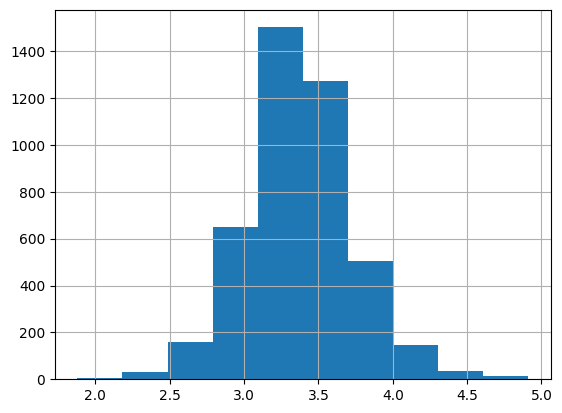

In [63]:
zscore_ratio_scores.hist()

In [65]:
zscore_ratio_scores.median(), zscore_ratio_scores.mean()

(3.358896247855225, 3.3731882594290488)

<Axes: >

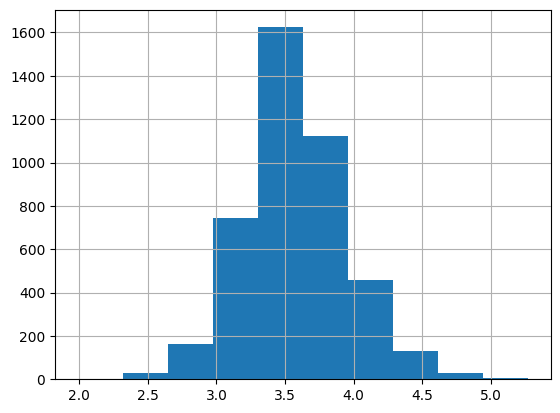

In [66]:
zscore_diff_scores.hist()

In [67]:
zscore_diff_scores.median(), zscore_diff_scores.mean()

(3.54875703013504, 3.5734920449651804)

<Axes: >

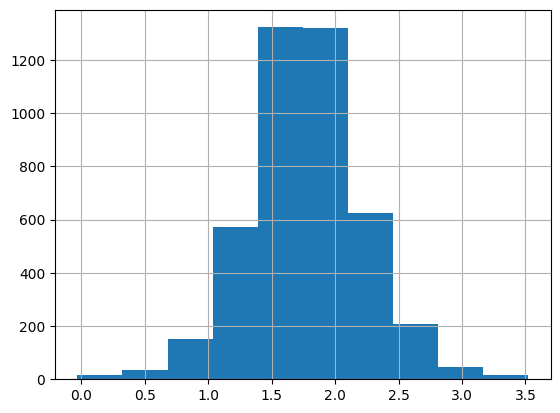

In [68]:
single_codon_ratio_scores.hist()

In [69]:
single_codon_ratio_scores.median(), single_codon_ratio_scores.mean()

(1.761985626429807, 1.7697639873201754)

<Axes: >

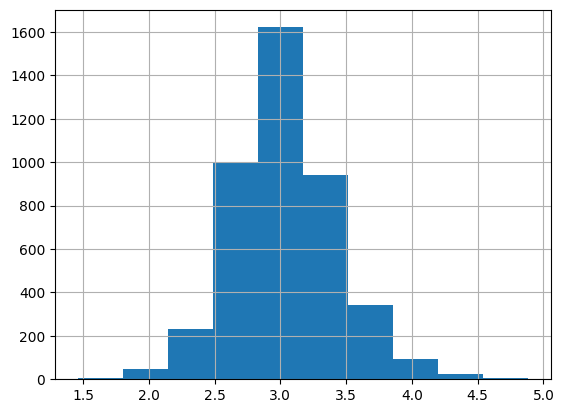

In [70]:
single_codon_diff_scores.hist()

In [71]:
single_codon_diff_scores.median(), single_codon_diff_scores.mean()

(3.004414336886932, 3.0324174767010317)

### Arapbidopsis microbiome

#### One wanted + One unwanted 

In [72]:
wanted_hosts = [
    "Paenibacillus-prosopidis.gb", 
     # "Arthrobacter-luteolus.gb",
]
unwanted_hosts = [
    "Yonghaparkia-alkaliphila.gb", 
     # "Brevibacterium-frigoritolerans.gb",
]

configuration = f"wanted_{'_'.join([host[:-3] for host in wanted_hosts])}_unwanted_{'_'.join([host[:-3] for host in unwanted_hosts])}"

#### Paenibacillus-prosopidis

In [73]:
organism = "Paenibacillus-prosopidis"
zscore_ratio_scores, zscore_diff_scores, single_codon_ratio_scores, single_codon_diff_scores = get_scores_for_organism_by_configuration(configuration, organism, "average_distance_score")

<Axes: >

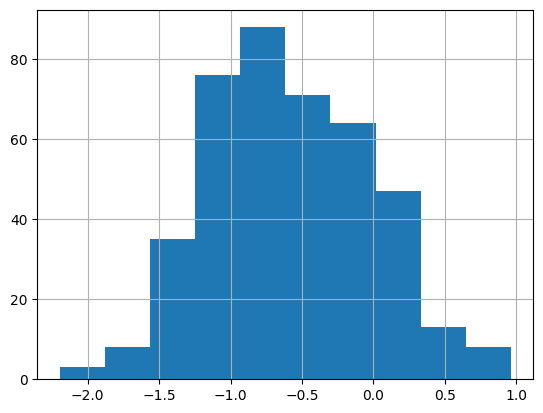

In [74]:
zscore_ratio_scores.hist()

In [75]:
zscore_ratio_scores.median(), zscore_ratio_scores.mean()

(-0.621373905029018, -0.5852485385948716)

<Axes: >

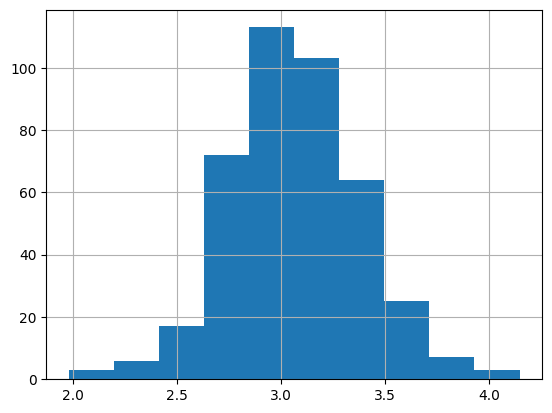

In [78]:
zscore_diff_scores.hist()

In [77]:
zscore_diff_scores.median(), zscore_diff_scores.mean()

(3.057759996984567, 3.068885026854632)

<Axes: >

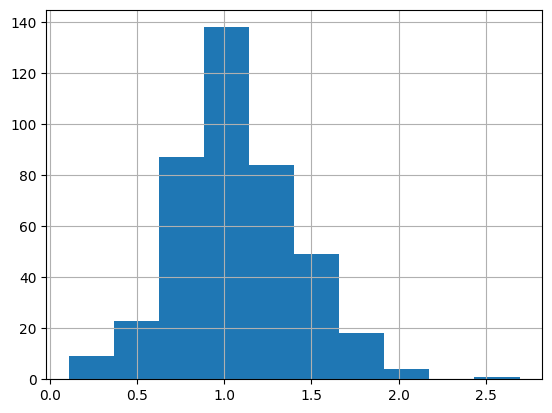

In [79]:
single_codon_diff_scores.hist()

In [80]:
single_codon_diff_scores.median(), single_codon_diff_scores.mean()

(1.028888618967053, 1.068933186424497)

<Axes: >

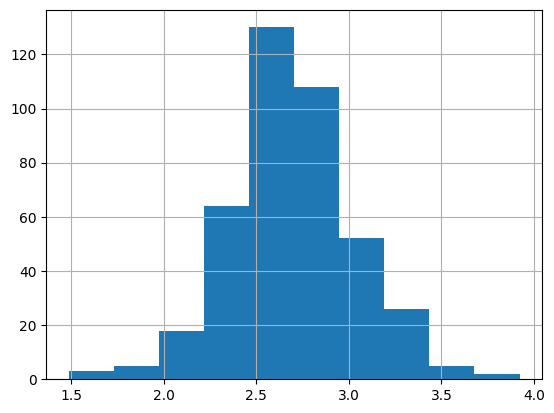

In [81]:
single_codon_ratio_scores.hist()

In [82]:
single_codon_ratio_scores.median(), single_codon_ratio_scores.mean()

(2.674001613380851, 2.6956382698640384)

### Yonghaparkia-alkaliphila

In [83]:
organism = "Yonghaparkia-alkaliphila"
zscore_ratio_scores, zscore_diff_scores, single_codon_ratio_scores, single_codon_diff_scores = get_scores_for_organism_by_configuration(configuration, organism, "average_distance_score")

<Axes: >

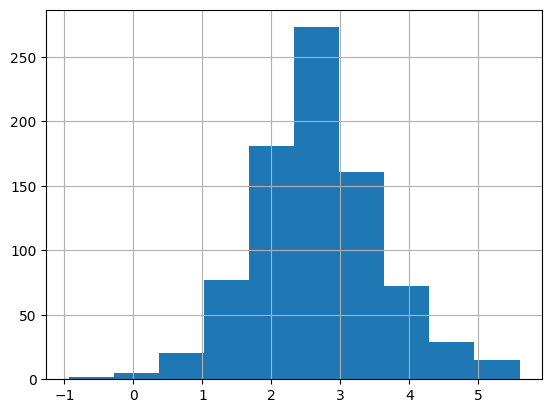

In [84]:
zscore_ratio_scores.hist()

In [85]:
zscore_ratio_scores.median(), zscore_ratio_scores.mean()

(2.633320000224408, 2.6887772009983424)

<Axes: >

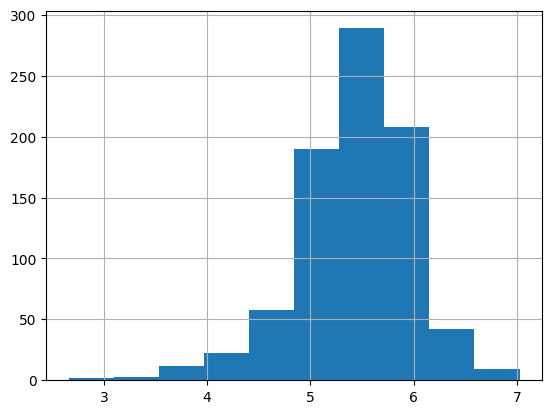

In [86]:
zscore_diff_scores.hist()

In [87]:
zscore_diff_scores.median(), zscore_diff_scores.mean()

(5.4726904840808075, 5.4278327691655575)

<Axes: >

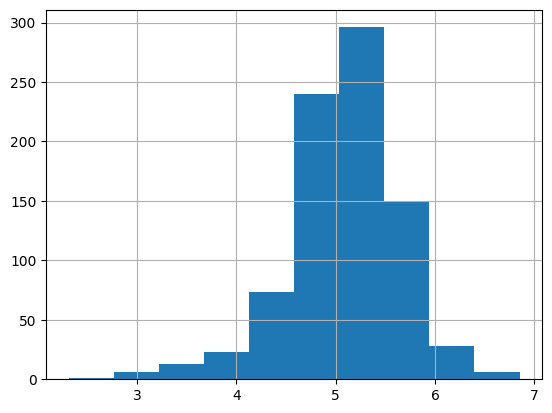

In [88]:
single_codon_ratio_scores.hist()

In [89]:
single_codon_ratio_scores.median(), single_codon_ratio_scores.mean()

(5.129253171975205, 5.083792309439488)

<Axes: >

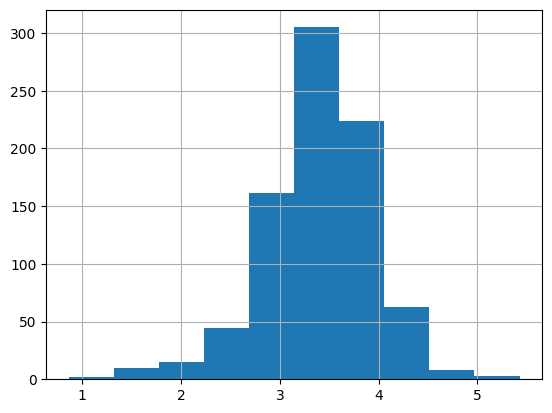

In [91]:
single_codon_diff_scores.hist()

In [92]:
single_codon_diff_scores.median(), single_codon_diff_scores.mean()

(3.421744077612472, 3.3937935654757188)

#### Two wanted + Two unwanted 

In [ ]:
wanted_hosts = [
    "Paenibacillus-aceris.gb", 
    "Arthrobacter-luteolus.gb",
]
unwanted_hosts = [
    "Terrabacter-tumescens.gb", 
    "Rhodanobacter-denitrificans.gb",
]

configuration = f"wanted_{'_'.join([host[:-3] for host in wanted_hosts])}_unwanted_{'_'.join([host[:-3] for host in unwanted_hosts])}"

#### Paenibacillus-aceris

In [ ]:
organism = "Paenibacillus-aceris"
zscore_ratio_scores, zscore_diff_scores, single_codon_ratio_scores, single_codon_diff_scores = get_scores_for_organism_by_configuration(configuration, organism, "average_distance_score")
zscore_ratio_weakest_link_scores, zscore_diff_weakest_link_scores, single_codon_ratio_weakest_link_scores, single_codon_diff_weakest_link_scores = get_scores_for_organism_by_configuration(configuration, organism, "weakest_link_score")